In [1]:
from datetime import timedelta
import torch
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models,transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader,random_split
from __future__ import print_function
import numpy as np 
import pandas as pd
import os
import time
import random
import matplotlib.pyplot as plt 
from torch.autograd import Function
from collections import OrderedDict
import torch.nn as nn
import math
import torchvision.models as models
import pickle
from tqdm.auto import tqdm
import cv2
# import wandb
from sklearn.model_selection import KFold
# from torchsummary import summary
import glob
from sklearn.manifold import TSNE
import seaborn as sns
import collections
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
import umap.umap_ as UMAP
import pims

/home/anagara8/.conda/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet18Enc(nn.Module):
    def __init__(self, z_dim=32):
        super(ResNet18Enc, self).__init__()
        self.z_dim = z_dim
        self.ResNet18 = models.resnet18(pretrained=True)
        self.num_feature = self.ResNet18.fc.in_features
        self.ResNet18.fc = nn.Linear(self.num_feature, 1*self.z_dim)
        
    def forward(self, x):
        x = self.ResNet18(x)
        return x

class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=32, nc=3):
        super().__init__()
        self.in_planes = 512

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)
        x = F.interpolate(x, scale_factor=7)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = F.interpolate(x, size=(112,112), mode='bilinear')
        x = torch.sigmoid(self.conv1(x))
        # [x, channels, height, width]
        x = x.view(x.size(0), 3, 224, 224)
        return x

class newAE(nn.Module):

    def __init__(self, z_dim):
        super(newAE, self).__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)

    def forward(self, x):
        z = self.encoder(x)
#         mean, logvar = self.encoder(x)
#         z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return x

    @staticmethod
    def reparameterize(mean, logvar):
        std = torch.exp(logvar / 2) # in log-space, squareroot is divide by two
        epsilon = torch.randn_like(std)
        return epsilon * std + mean

In [3]:
ae_model_mse = newAE(32)
ae_model_mse = nn.DataParallel(ae_model_mse)
ae_model_mse = ae_model_mse.cuda()
ae_model_mse.load_state_dict(torch.load("new_architecture_MSE_e2400.p"))
ae_model_mse.eval()

DataParallel(
  (module): newAE(
    (encoder): ResNet18Enc(
      (ResNet18): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(

In [4]:
# Loading all frames
start = time.time()
all_frames_list = np.load("all_frame_and_action_list.npy")
end = time.time()
print("Training File List containing", len(all_frames_list), "frames loaded in:", end - start)

Training File List containing 8387210 frames loaded in: 1.0353202819824219


In [5]:
random.seed(42)
random.shuffle(all_frames_list)

In [6]:
# Removing the Control Animals

# Control animal camera IDs:
control_animal_list = ["cam_17202338",
                        "cam_17202345",
                        "cam_17202346",#('9')
                        "cam_6394839",
                        "cam_6394846",
                        "cam_6394840"]

control_animal_samples = []

# Store indices for poping
control_animal_indices = []

# Convert from Numpy Array to Python List
final_training_list = all_frames_list
# Create a copy for sanity checks
final_training_list2 = []

training_latents = []
training_labels = []

testing_latents = []
testing_labels = []

for idx in range(len(final_training_list)):
    # We know all control animals are from FC-D
    animal_found = False
    if "FC-D" in final_training_list[idx]:
        for control_animal in control_animal_list:
            if control_animal in final_training_list[idx]:
                control_animal_samples.append(final_training_list[idx])
                control_animal_indices.append(idx)
                animal_found = True
#     if not animal_found:
#         training_latents.append(all_latents_array[idx])
#         training_labels.append(all_labels_array[idx])
#     else:
#         testing_latents.append(all_latents_array[idx])
#         testing_labels.append(all_labels_array[idx])
            
initial_training_set = set(final_training_list)
control_set = set(control_animal_samples)
final_training_list2 = list(initial_training_set-control_set)

print("Length of untouched Training list:", len(final_training_list))
print("Length of training list without control animals:", len(final_training_list2))
print("Length of control animal list:", len(control_animal_samples))
print("Length of edited training + control animals:", len(control_animal_samples) + len(final_training_list2))
# print("Length of corresponding latents and labels:", len(training_latents), len(training_labels))
# print("Length of Testing vectors:", len(testing_latents))

Length of untouched Training list: 8387210
Length of training list without control animals: 6688187
Length of control animal list: 1699023
Length of edited training + control animals: 8387210


In [7]:
# Create a training list of 1mil files
final_training_list = []

preexposure_count = 0
postcond_count = 0
postext_count = 0
postret_count = 0

# 1353968 -> Number of frames of postret (smallest class)
for sample in final_training_list2:
    if "preexposure" in sample:
        if preexposure_count < 250000:
            final_training_list.append(sample)
            preexposure_count += 1
    elif "postcond" in sample:
        if postcond_count < 250000:
            final_training_list.append(sample)
            postcond_count += 1
    elif "postext" in sample:
        if postext_count < 250000:
            final_training_list.append(sample)
            postext_count += 1
    elif "postret" in sample:
        if postret_count < 250000:
            final_training_list.append(sample)
            postret_count += 1
            
print("Length of final_training_list:", len(final_training_list), "with", preexposure_count, "Preexposure", postcond_count, "Postcond", postext_count, "Postext", postret_count, "Postret.")

Length of final_training_list: 1000000 with 250000 Preexposure 250000 Postcond 250000 Postext 250000 Postret.


In [8]:
all_labels_array = []
all_latents_array = []

In [ ]:
image_count = 0

for image in final_training_list[len(all_labels_array):]:
    image_count += 1
    if image_count % 10000 == 0:
        print("Processed", image_count, "Images..")
    name = image
    if "preexposure" in name:
        append_name = "/media/data_cifs/anagara8/preexposure_action/"
    elif "postcond" in name:
        append_name = "/media/data_cifs/anagara8/postcond_action/"
    elif "postext" in name:
        append_name = "/media/data_cifs/anagara8/postext_action/"
    elif "postret" in name:
        append_name = "/media/data_cifs/anagara8/postret_action/"
    
    image = cv2.imread(append_name + image)
    image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_AREA)
    tensor_frame = torchvision.transforms.functional.to_tensor(image).unsqueeze(0).cuda()
    with torch.no_grad():
        latent_representation = ae_model_mse.module.encoder(tensor_frame)
    all_latents_array.append(latent_representation.squeeze().cpu().numpy())
    
    # Append One Hot encoded Labels
    if "preexposure" in name:
        all_labels_array.append([1.0, 0.0, 0.0, 0.0])
    elif "postcond" in name:
        all_labels_array.append([0.0, 1.0, 0.0, 0.0])
    elif "postext" in name:
        all_labels_array.append([0.0, 0.0, 1.0, 0.0])
    elif "postret" in name:
        all_labels_array.append([0.0, 0.0, 0.0, 1.0])
    else:
        print("ERROR: Incorrect Experiment Phase, no label associated.")

        
print("All done!")

Processed 10000 Images..


In [29]:
len(all_latents_array)

1000000

In [9]:
# np.save("1mil_latents_array_mse_model.npy", all_latents_array)
all_latents_array = np.load("1mil_latents_array_mse_model.npy")

In [10]:
final_training_list[0]

'FC-B_1-6_postretrieval_09-26_09-28video_2018Y_09M_27D_00h_39m_46s_cam_17202346-0000_45652.jpg'

In [11]:
frame_names = []
for image in final_training_list:
    name = image
    if "preexposure" in name:
        append_name = "/media/data_cifs/anagara8/preexposure_action/"+name
    elif "postcond" in name:
        append_name = "/media/data_cifs/anagara8/postcond_action/"+name
    elif "postext" in name:
        append_name = "/media/data_cifs/anagara8/postext_action/"+name
    elif "postret" in name:
        append_name = "/media/data_cifs/anagara8/postret_action/"+name
    frame_names.append(append_name)

In [12]:
# np.save("1mil_latents_array_mse_modelFRAMES.npy", frame_names)
frame_names = np.load("1mil_latents_array_mse_modelFRAMES.npy")

In [13]:
len(frame_names)

1000000

In [14]:
frame_names[1]

'/media/data_cifs/anagara8/postext_action/'

In [15]:
for image in final_training_list:
    name = image
    if "preexposure" in name:
        all_labels_array.append([1.0, 0.0, 0.0, 0.0])
    elif "postcond" in name:
        all_labels_array.append([0.0, 1.0, 0.0, 0.0])
    elif "postext" in name:
        all_labels_array.append([0.0, 0.0, 1.0, 0.0])
    elif "postret" in name:
        all_labels_array.append([0.0, 0.0, 0.0, 1.0])
    else:
        print("ERROR: Incorrect Experiment Phase, no label associated.")

In [16]:
# np.save("1mil_labels_array_mse_model.npy", all_labels_array)

In [17]:
len(all_latents_array)

1000000

In [18]:
# Creating the DataLoader
class LatentDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, augmentations = None):
        super(LatentDataset, self).__init__()
        
        # Latents are stored as the first element
        self.vector_list = [item[0] for item in dataset]
        # Labels are stored as the second element
        self.label_list = [item[1] for item in dataset]
        
        self.augmentations = augmentations
    
    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, idx):
        vector = torch.tensor(self.vector_list[idx])
        label = torch.tensor(self.label_list[idx])
        return vector, label

In [19]:
m = len(all_latents_array)
test_train_split = 0.2

torch.manual_seed(42)

train_data, val_data = random_split(list(zip(all_latents_array, all_labels_array)), [int(math.ceil(m-m*test_train_split)), int(m*test_train_split)])
print("Length:", len(train_data) + len(val_data), "-> Training set size:", len(train_data), "| Validation set size:", len(val_data))

# train_data, val_data = random_split(list(zip(all_latents_array, all_labels_array)), [int(math.ceil(m-m*test_train_split)), int(m*test_train_split)])
# print("Length:", len(train_data) + len(val_data), "-> Training set size:", len(train_data), "| Validation set size:", len(val_data))

Length: 1000000 -> Training set size: 800000 | Validation set size: 200000


In [20]:
train_dataset = LatentDataset(train_data)
val_dataset = LatentDataset(val_data)

In [21]:
batch_size = 512

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers = 4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers = 4, shuffle=False)

In [42]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 128)
        self.hidden_fc1 = nn.Linear(128, 64)
        self.hidden_fc2 = nn.Linear(64, 32)
        self.output_fc = nn.Linear(32, output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = F.relu(self.input_fc(x))
        h_2 = F.relu(self.hidden_fc1(h_1))
        h_3 = F.relu(self.hidden_fc2(h_2))
        y_out = self.output_fc(h_3)
        y_pred = torch.sigmoid(y_out)
        
        return y_out

In [43]:
INPUT_DIM = 32
OUTPUT_DIM = 4

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", device)

Using cuda


In [45]:
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.000001)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [46]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def calculate_accuracy(y_pred, y):
    y_pred = torch.argmax(y_pred, dim = 1)
    y = torch.argmax(y, dim = 1)
    
    acc = torch.unique(y_pred[y_pred==y], return_counts = True)[1].sum()
    acc = acc / y.shape[0]
    return acc

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,692 trainable parameters


In [47]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
        for sample in tqdm(iterator, desc="Validating", leave=False):
            latent, label = sample
        
            latent = latent.to(device)
            label = label.squeeze().to(device)
            
            y_pred = model(latent)

            loss = criterion(y_pred, label)
            acc = calculate_accuracy(y_pred, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [48]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for sample in tqdm(iterator, desc="Training", leave=False):
        latent, label = sample
        
        latent = latent.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        y_pred = model(latent)

        loss = criterion(y_pred, label)
        acc = calculate_accuracy(y_pred, label)
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
EPOCHS = 150
best_valid_loss = float('inf')
list_train_loss = []
list_val_loss = []

list_train_acc = []
list_val_acc = []

In [56]:
for epoch in range(EPOCHS):
    start_time = time.monotonic()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, device)
    
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.7f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.7f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    list_val_loss.append(valid_loss)
    list_train_loss.append(train_loss)
    
    list_val_acc.append(valid_acc)
    list_train_acc.append(train_acc)
    
    if (epoch %20 == 0 or (epoch > 200 and epoch %5 == 0))and valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "./LinearClassifierFinal/no_control_in_training_MSE_e"+str(epoch)+"_v"+str(valid_acc)+".p")
print('Finished Training')

Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 0.1207627 | Train Acc: 97.33%
	 Val. Loss: 0.1208265 |  Val. Acc: 97.34%


Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 0.1191260 | Train Acc: 97.36%
	 Val. Loss: 0.1191884 |  Val. Acc: 97.37%


Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 0.1174995 | Train Acc: 97.40%
	 Val. Loss: 0.1175920 |  Val. Acc: 97.41%


Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 0.1159283 | Train Acc: 97.43%
	 Val. Loss: 0.1160249 |  Val. Acc: 97.44%


Epoch: 05 | Epoch Time: 0m 12s
	Train Loss: 0.1143663 | Train Acc: 97.47%
	 Val. Loss: 0.1144978 |  Val. Acc: 97.47%


Epoch: 06 | Epoch Time: 0m 12s
	Train Loss: 0.1128453 | Train Acc: 97.50%
	 Val. Loss: 0.1129595 |  Val. Acc: 97.50%


Epoch: 07 | Epoch Time: 0m 12s
	Train Loss: 0.1113277 | Train Acc: 97.53%
	 Val. Loss: 0.1114782 |  Val. Acc: 97.53%


Epoch: 08 | Epoch Time: 0m 12s
	Train Loss: 0.1098659 | Train Acc: 97.56%
	 Val. Loss: 0.1100192 |  Val. Acc: 97.56%


Epoch: 09 | Epoch Time: 0m 12s
	Train Loss: 0.1084012 | Train Acc: 97.58%
	 Val. Loss: 0.1085866 |  Val. Acc: 97.58%


Epoch: 10 | Epoch Time: 0m 11s
	Train Loss: 0.1069608 | Train Acc: 97.62%
	 Val. Loss: 0.1071585 |  Val. Acc: 97.62%


Epoch: 11 | Epoch Time: 0m 11s
	Train Loss: 0.1055686 | Train Acc: 97.64%
	 Val. Loss: 0.1057879 |  Val. Acc: 97.64%


Epoch: 12 | Epoch Time: 0m 11s
	Train Loss: 0.1041982 | Train Acc: 97.68%
	 Val. Loss: 0.1044277 |  Val. Acc: 97.68%


Epoch: 13 | Epoch Time: 0m 12s
	Train Loss: 0.1028387 | Train Acc: 97.71%
	 Val. Loss: 0.1030908 |  Val. Acc: 97.69%


Epoch: 14 | Epoch Time: 0m 11s
	Train Loss: 0.1015150 | Train Acc: 97.74%
	 Val. Loss: 0.1017876 |  Val. Acc: 97.72%


Epoch: 15 | Epoch Time: 0m 12s
	Train Loss: 0.1002102 | Train Acc: 97.77%
	 Val. Loss: 0.1004889 |  Val. Acc: 97.75%


Epoch: 16 | Epoch Time: 0m 12s
	Train Loss: 0.0989338 | Train Acc: 97.79%
	 Val. Loss: 0.0992418 |  Val. Acc: 97.77%


Epoch: 17 | Epoch Time: 0m 12s
	Train Loss: 0.0976926 | Train Acc: 97.82%
	 Val. Loss: 0.0980092 |  Val. Acc: 97.80%


Epoch: 18 | Epoch Time: 0m 12s
	Train Loss: 0.0964592 | Train Acc: 97.85%
	 Val. Loss: 0.0967849 |  Val. Acc: 97.82%


Epoch: 19 | Epoch Time: 0m 12s
	Train Loss: 0.0952488 | Train Acc: 97.87%
	 Val. Loss: 0.0955921 |  Val. Acc: 97.83%


Epoch: 20 | Epoch Time: 0m 11s
	Train Loss: 0.0940729 | Train Acc: 97.89%
	 Val. Loss: 0.0944137 |  Val. Acc: 97.85%


Epoch: 21 | Epoch Time: 0m 11s
	Train Loss: 0.0929052 | Train Acc: 97.91%
	 Val. Loss: 0.0932695 |  Val. Acc: 97.88%


Epoch: 22 | Epoch Time: 0m 10s
	Train Loss: 0.0917647 | Train Acc: 97.94%
	 Val. Loss: 0.0921420 |  Val. Acc: 97.90%


Epoch: 23 | Epoch Time: 0m 11s
	Train Loss: 0.0906395 | Train Acc: 97.96%
	 Val. Loss: 0.0910218 |  Val. Acc: 97.92%


Epoch: 24 | Epoch Time: 0m 11s
	Train Loss: 0.0895385 | Train Acc: 97.99%
	 Val. Loss: 0.0899386 |  Val. Acc: 97.94%


Epoch: 25 | Epoch Time: 0m 11s
	Train Loss: 0.0884662 | Train Acc: 98.01%
	 Val. Loss: 0.0888679 |  Val. Acc: 97.97%


Epoch: 26 | Epoch Time: 0m 12s
	Train Loss: 0.0874051 | Train Acc: 98.03%
	 Val. Loss: 0.0878332 |  Val. Acc: 98.00%


Epoch: 27 | Epoch Time: 0m 12s
	Train Loss: 0.0863592 | Train Acc: 98.06%
	 Val. Loss: 0.0867997 |  Val. Acc: 98.02%


Epoch: 28 | Epoch Time: 0m 12s
	Train Loss: 0.0853323 | Train Acc: 98.08%
	 Val. Loss: 0.0857658 |  Val. Acc: 98.03%


Epoch: 29 | Epoch Time: 0m 12s
	Train Loss: 0.0843335 | Train Acc: 98.10%
	 Val. Loss: 0.0847656 |  Val. Acc: 98.05%


Epoch: 30 | Epoch Time: 0m 12s
	Train Loss: 0.0833270 | Train Acc: 98.12%
	 Val. Loss: 0.0837767 |  Val. Acc: 98.07%


Epoch: 31 | Epoch Time: 0m 11s
	Train Loss: 0.0823604 | Train Acc: 98.14%
	 Val. Loss: 0.0828236 |  Val. Acc: 98.09%


Epoch: 32 | Epoch Time: 0m 11s
	Train Loss: 0.0813925 | Train Acc: 98.17%
	 Val. Loss: 0.0818750 |  Val. Acc: 98.12%


Epoch: 33 | Epoch Time: 0m 11s
	Train Loss: 0.0804543 | Train Acc: 98.19%
	 Val. Loss: 0.0809469 |  Val. Acc: 98.14%


Epoch: 34 | Epoch Time: 0m 11s
	Train Loss: 0.0795366 | Train Acc: 98.21%
	 Val. Loss: 0.0800297 |  Val. Acc: 98.16%


Epoch: 35 | Epoch Time: 0m 12s
	Train Loss: 0.0786206 | Train Acc: 98.23%
	 Val. Loss: 0.0791286 |  Val. Acc: 98.18%


Epoch: 36 | Epoch Time: 0m 12s
	Train Loss: 0.0777375 | Train Acc: 98.24%
	 Val. Loss: 0.0782394 |  Val. Acc: 98.20%


Epoch: 37 | Epoch Time: 0m 12s
	Train Loss: 0.0768525 | Train Acc: 98.26%
	 Val. Loss: 0.0773666 |  Val. Acc: 98.21%


Epoch: 38 | Epoch Time: 0m 12s
	Train Loss: 0.0759878 | Train Acc: 98.28%
	 Val. Loss: 0.0765163 |  Val. Acc: 98.22%


Epoch: 39 | Epoch Time: 0m 12s
	Train Loss: 0.0751510 | Train Acc: 98.30%
	 Val. Loss: 0.0756769 |  Val. Acc: 98.24%


Epoch: 40 | Epoch Time: 0m 11s
	Train Loss: 0.0743000 | Train Acc: 98.32%
	 Val. Loss: 0.0748536 |  Val. Acc: 98.25%


Epoch: 41 | Epoch Time: 0m 11s
	Train Loss: 0.0734788 | Train Acc: 98.34%
	 Val. Loss: 0.0740433 |  Val. Acc: 98.27%


Epoch: 42 | Epoch Time: 0m 11s
	Train Loss: 0.0726717 | Train Acc: 98.36%
	 Val. Loss: 0.0732457 |  Val. Acc: 98.30%


Epoch: 43 | Epoch Time: 0m 11s
	Train Loss: 0.0719029 | Train Acc: 98.37%
	 Val. Loss: 0.0724483 |  Val. Acc: 98.32%


Epoch: 44 | Epoch Time: 0m 11s
	Train Loss: 0.0711147 | Train Acc: 98.39%
	 Val. Loss: 0.0716874 |  Val. Acc: 98.33%


Epoch: 45 | Epoch Time: 0m 12s
	Train Loss: 0.0703408 | Train Acc: 98.41%
	 Val. Loss: 0.0709250 |  Val. Acc: 98.35%


Epoch: 46 | Epoch Time: 0m 12s
	Train Loss: 0.0695900 | Train Acc: 98.42%
	 Val. Loss: 0.0701865 |  Val. Acc: 98.36%


Epoch: 47 | Epoch Time: 0m 13s
	Train Loss: 0.0688523 | Train Acc: 98.43%
	 Val. Loss: 0.0694656 |  Val. Acc: 98.38%


Epoch: 48 | Epoch Time: 0m 12s
	Train Loss: 0.0681328 | Train Acc: 98.45%
	 Val. Loss: 0.0687318 |  Val. Acc: 98.40%


Epoch: 49 | Epoch Time: 0m 12s
	Train Loss: 0.0674203 | Train Acc: 98.47%
	 Val. Loss: 0.0680268 |  Val. Acc: 98.41%


Epoch: 50 | Epoch Time: 0m 11s
	Train Loss: 0.0667170 | Train Acc: 98.48%
	 Val. Loss: 0.0673335 |  Val. Acc: 98.42%


Epoch: 51 | Epoch Time: 0m 12s
	Train Loss: 0.0660322 | Train Acc: 98.49%
	 Val. Loss: 0.0666517 |  Val. Acc: 98.43%


Epoch: 52 | Epoch Time: 0m 12s
	Train Loss: 0.0653465 | Train Acc: 98.51%
	 Val. Loss: 0.0660044 |  Val. Acc: 98.45%


Epoch: 53 | Epoch Time: 0m 11s
	Train Loss: 0.0646882 | Train Acc: 98.52%
	 Val. Loss: 0.0653238 |  Val. Acc: 98.46%


Epoch: 54 | Epoch Time: 0m 11s
	Train Loss: 0.0640246 | Train Acc: 98.54%
	 Val. Loss: 0.0646622 |  Val. Acc: 98.47%


Epoch: 55 | Epoch Time: 0m 12s
	Train Loss: 0.0633825 | Train Acc: 98.55%
	 Val. Loss: 0.0640136 |  Val. Acc: 98.49%


Epoch: 56 | Epoch Time: 0m 11s
	Train Loss: 0.0627457 | Train Acc: 98.56%
	 Val. Loss: 0.0633916 |  Val. Acc: 98.51%


Epoch: 57 | Epoch Time: 0m 12s
	Train Loss: 0.0621172 | Train Acc: 98.58%
	 Val. Loss: 0.0627674 |  Val. Acc: 98.52%


Epoch: 58 | Epoch Time: 0m 12s
	Train Loss: 0.0615073 | Train Acc: 98.59%
	 Val. Loss: 0.0621600 |  Val. Acc: 98.53%


Epoch: 59 | Epoch Time: 0m 12s
	Train Loss: 0.0609017 | Train Acc: 98.60%
	 Val. Loss: 0.0615694 |  Val. Acc: 98.55%


Epoch: 60 | Epoch Time: 0m 11s
	Train Loss: 0.0603141 | Train Acc: 98.61%
	 Val. Loss: 0.0609628 |  Val. Acc: 98.56%


Epoch: 61 | Epoch Time: 0m 11s
	Train Loss: 0.0597288 | Train Acc: 98.62%
	 Val. Loss: 0.0603875 |  Val. Acc: 98.58%


Epoch: 62 | Epoch Time: 0m 11s
	Train Loss: 0.0591449 | Train Acc: 98.64%
	 Val. Loss: 0.0597988 |  Val. Acc: 98.59%


Epoch: 63 | Epoch Time: 0m 11s
	Train Loss: 0.0585784 | Train Acc: 98.65%
	 Val. Loss: 0.0592452 |  Val. Acc: 98.60%


Epoch: 64 | Epoch Time: 0m 11s
	Train Loss: 0.0580113 | Train Acc: 98.66%
	 Val. Loss: 0.0586868 |  Val. Acc: 98.62%


Epoch: 65 | Epoch Time: 0m 12s
	Train Loss: 0.0574677 | Train Acc: 98.67%
	 Val. Loss: 0.0581500 |  Val. Acc: 98.63%


Epoch: 66 | Epoch Time: 0m 12s
	Train Loss: 0.0569295 | Train Acc: 98.68%
	 Val. Loss: 0.0575930 |  Val. Acc: 98.64%


Epoch: 67 | Epoch Time: 0m 12s
	Train Loss: 0.0563968 | Train Acc: 98.70%
	 Val. Loss: 0.0570659 |  Val. Acc: 98.64%


Epoch: 68 | Epoch Time: 0m 12s
	Train Loss: 0.0558808 | Train Acc: 98.71%
	 Val. Loss: 0.0565541 |  Val. Acc: 98.66%


Epoch: 69 | Epoch Time: 0m 12s
	Train Loss: 0.0553668 | Train Acc: 98.72%
	 Val. Loss: 0.0560545 |  Val. Acc: 98.68%


Epoch: 70 | Epoch Time: 0m 11s
	Train Loss: 0.0548546 | Train Acc: 98.73%
	 Val. Loss: 0.0555364 |  Val. Acc: 98.69%


Epoch: 71 | Epoch Time: 0m 12s
	Train Loss: 0.0543498 | Train Acc: 98.74%
	 Val. Loss: 0.0550344 |  Val. Acc: 98.69%


Epoch: 72 | Epoch Time: 0m 11s
	Train Loss: 0.0538681 | Train Acc: 98.75%
	 Val. Loss: 0.0545434 |  Val. Acc: 98.70%


Epoch: 73 | Epoch Time: 0m 11s
	Train Loss: 0.0534002 | Train Acc: 98.76%
	 Val. Loss: 0.0540636 |  Val. Acc: 98.71%


Epoch: 74 | Epoch Time: 0m 11s
	Train Loss: 0.0530120 | Train Acc: 98.77%
	 Val. Loss: 0.0535870 |  Val. Acc: 98.72%


Epoch: 75 | Epoch Time: 0m 12s
	Train Loss: 0.0524340 | Train Acc: 98.78%
	 Val. Loss: 0.0531237 |  Val. Acc: 98.73%


Epoch: 76 | Epoch Time: 0m 11s
	Train Loss: 0.0519707 | Train Acc: 98.79%
	 Val. Loss: 0.0526572 |  Val. Acc: 98.74%


Epoch: 77 | Epoch Time: 0m 12s
	Train Loss: 0.0515219 | Train Acc: 98.80%
	 Val. Loss: 0.0522011 |  Val. Acc: 98.75%


Epoch: 78 | Epoch Time: 0m 12s
	Train Loss: 0.0510691 | Train Acc: 98.81%
	 Val. Loss: 0.0517489 |  Val. Acc: 98.75%


Epoch: 79 | Epoch Time: 0m 12s
	Train Loss: 0.0506245 | Train Acc: 98.82%
	 Val. Loss: 0.0513277 |  Val. Acc: 98.77%


Epoch: 80 | Epoch Time: 0m 12s
	Train Loss: 0.0501840 | Train Acc: 98.83%
	 Val. Loss: 0.0508788 |  Val. Acc: 98.78%


Epoch: 81 | Epoch Time: 0m 11s
	Train Loss: 0.0497539 | Train Acc: 98.84%
	 Val. Loss: 0.0504389 |  Val. Acc: 98.78%


Epoch: 82 | Epoch Time: 0m 10s
	Train Loss: 0.0493275 | Train Acc: 98.84%
	 Val. Loss: 0.0500111 |  Val. Acc: 98.79%


Epoch: 83 | Epoch Time: 0m 11s
	Train Loss: 0.0489113 | Train Acc: 98.85%
	 Val. Loss: 0.0495996 |  Val. Acc: 98.80%


Epoch: 84 | Epoch Time: 0m 11s
	Train Loss: 0.0484953 | Train Acc: 98.86%
	 Val. Loss: 0.0491870 |  Val. Acc: 98.81%


Epoch: 85 | Epoch Time: 0m 12s
	Train Loss: 0.0480897 | Train Acc: 98.87%
	 Val. Loss: 0.0487841 |  Val. Acc: 98.81%


Epoch: 86 | Epoch Time: 0m 12s
	Train Loss: 0.0476942 | Train Acc: 98.88%
	 Val. Loss: 0.0483803 |  Val. Acc: 98.83%


Epoch: 87 | Epoch Time: 0m 12s
	Train Loss: 0.0473053 | Train Acc: 98.89%
	 Val. Loss: 0.0479878 |  Val. Acc: 98.84%


Epoch: 88 | Epoch Time: 0m 12s
	Train Loss: 0.0469094 | Train Acc: 98.90%
	 Val. Loss: 0.0475890 |  Val. Acc: 98.85%


Epoch: 89 | Epoch Time: 0m 12s
	Train Loss: 0.0465254 | Train Acc: 98.90%
	 Val. Loss: 0.0472083 |  Val. Acc: 98.85%


Epoch: 90 | Epoch Time: 0m 12s
	Train Loss: 0.0461472 | Train Acc: 98.91%
	 Val. Loss: 0.0468249 |  Val. Acc: 98.86%


Epoch: 91 | Epoch Time: 0m 12s
	Train Loss: 0.0457684 | Train Acc: 98.92%
	 Val. Loss: 0.0464526 |  Val. Acc: 98.87%


Epoch: 92 | Epoch Time: 0m 11s
	Train Loss: 0.0454027 | Train Acc: 98.92%
	 Val. Loss: 0.0460846 |  Val. Acc: 98.88%


Epoch: 93 | Epoch Time: 0m 11s
	Train Loss: 0.0450359 | Train Acc: 98.93%
	 Val. Loss: 0.0457135 |  Val. Acc: 98.88%


Epoch: 94 | Epoch Time: 0m 11s
	Train Loss: 0.0446852 | Train Acc: 98.94%
	 Val. Loss: 0.0453479 |  Val. Acc: 98.89%


Epoch: 95 | Epoch Time: 0m 11s
	Train Loss: 0.0443162 | Train Acc: 98.95%
	 Val. Loss: 0.0449945 |  Val. Acc: 98.90%


Epoch: 96 | Epoch Time: 0m 12s
	Train Loss: 0.0439670 | Train Acc: 98.96%
	 Val. Loss: 0.0446438 |  Val. Acc: 98.91%


Epoch: 97 | Epoch Time: 0m 12s
	Train Loss: 0.0436212 | Train Acc: 98.96%
	 Val. Loss: 0.0443066 |  Val. Acc: 98.91%


Epoch: 98 | Epoch Time: 0m 12s
	Train Loss: 0.0432789 | Train Acc: 98.97%
	 Val. Loss: 0.0439520 |  Val. Acc: 98.92%


Epoch: 99 | Epoch Time: 0m 12s
	Train Loss: 0.0429469 | Train Acc: 98.98%
	 Val. Loss: 0.0436219 |  Val. Acc: 98.93%


Epoch: 100 | Epoch Time: 0m 12s
	Train Loss: 0.0426091 | Train Acc: 98.98%
	 Val. Loss: 0.0432848 |  Val. Acc: 98.94%


Epoch: 101 | Epoch Time: 0m 12s
	Train Loss: 0.0422773 | Train Acc: 98.99%
	 Val. Loss: 0.0429712 |  Val. Acc: 98.95%


Epoch: 102 | Epoch Time: 0m 11s
	Train Loss: 0.0419568 | Train Acc: 99.00%
	 Val. Loss: 0.0426171 |  Val. Acc: 98.95%


Epoch: 103 | Epoch Time: 0m 11s
	Train Loss: 0.0416324 | Train Acc: 99.01%
	 Val. Loss: 0.0422976 |  Val. Acc: 98.96%


Epoch: 104 | Epoch Time: 0m 11s
	Train Loss: 0.0413225 | Train Acc: 99.01%
	 Val. Loss: 0.0419788 |  Val. Acc: 98.97%


Epoch: 105 | Epoch Time: 0m 18s
	Train Loss: 0.0410105 | Train Acc: 99.02%
	 Val. Loss: 0.0416600 |  Val. Acc: 98.98%


Epoch: 106 | Epoch Time: 0m 12s
	Train Loss: 0.0407011 | Train Acc: 99.03%
	 Val. Loss: 0.0413544 |  Val. Acc: 98.99%


Epoch: 107 | Epoch Time: 0m 12s
	Train Loss: 0.0403949 | Train Acc: 99.04%
	 Val. Loss: 0.0410491 |  Val. Acc: 99.00%


Epoch: 108 | Epoch Time: 0m 12s
	Train Loss: 0.0400953 | Train Acc: 99.04%
	 Val. Loss: 0.0407445 |  Val. Acc: 99.00%


Epoch: 109 | Epoch Time: 0m 12s
	Train Loss: 0.0398007 | Train Acc: 99.06%
	 Val. Loss: 0.0404604 |  Val. Acc: 99.02%


Epoch: 110 | Epoch Time: 0m 12s
	Train Loss: 0.0395073 | Train Acc: 99.06%
	 Val. Loss: 0.0401592 |  Val. Acc: 99.01%


Epoch: 111 | Epoch Time: 0m 11s
	Train Loss: 0.0392175 | Train Acc: 99.07%
	 Val. Loss: 0.0398620 |  Val. Acc: 99.03%


Epoch: 112 | Epoch Time: 0m 11s
	Train Loss: 0.0389402 | Train Acc: 99.08%
	 Val. Loss: 0.0395749 |  Val. Acc: 99.04%


Epoch: 113 | Epoch Time: 0m 11s
	Train Loss: 0.0386471 | Train Acc: 99.08%
	 Val. Loss: 0.0393040 |  Val. Acc: 99.05%


Epoch: 114 | Epoch Time: 0m 12s
	Train Loss: 0.0383717 | Train Acc: 99.09%
	 Val. Loss: 0.0390198 |  Val. Acc: 99.06%


Epoch: 115 | Epoch Time: 0m 12s
	Train Loss: 0.0380981 | Train Acc: 99.10%
	 Val. Loss: 0.0387421 |  Val. Acc: 99.07%


Epoch: 116 | Epoch Time: 0m 12s
	Train Loss: 0.0378224 | Train Acc: 99.11%
	 Val. Loss: 0.0384594 |  Val. Acc: 99.07%


Epoch: 117 | Epoch Time: 0m 12s
	Train Loss: 0.0375495 | Train Acc: 99.11%
	 Val. Loss: 0.0381846 |  Val. Acc: 99.08%


Epoch: 118 | Epoch Time: 0m 12s
	Train Loss: 0.0372881 | Train Acc: 99.12%
	 Val. Loss: 0.0379278 |  Val. Acc: 99.09%


Epoch: 119 | Epoch Time: 0m 12s
	Train Loss: 0.0370424 | Train Acc: 99.13%
	 Val. Loss: 0.0376432 |  Val. Acc: 99.09%


Epoch: 120 | Epoch Time: 0m 12s
	Train Loss: 0.0367637 | Train Acc: 99.14%
	 Val. Loss: 0.0373833 |  Val. Acc: 99.09%


Epoch: 121 | Epoch Time: 0m 11s
	Train Loss: 0.0365039 | Train Acc: 99.15%
	 Val. Loss: 0.0371357 |  Val. Acc: 99.11%


Epoch: 122 | Epoch Time: 0m 11s
	Train Loss: 0.0362465 | Train Acc: 99.16%
	 Val. Loss: 0.0368658 |  Val. Acc: 99.11%


Epoch: 123 | Epoch Time: 0m 11s
	Train Loss: 0.0360034 | Train Acc: 99.16%
	 Val. Loss: 0.0366056 |  Val. Acc: 99.12%


Epoch: 124 | Epoch Time: 0m 11s
	Train Loss: 0.0357449 | Train Acc: 99.17%
	 Val. Loss: 0.0363554 |  Val. Acc: 99.12%


Epoch: 125 | Epoch Time: 0m 12s
	Train Loss: 0.0355014 | Train Acc: 99.18%
	 Val. Loss: 0.0361131 |  Val. Acc: 99.13%


Epoch: 126 | Epoch Time: 0m 12s
	Train Loss: 0.0352586 | Train Acc: 99.18%
	 Val. Loss: 0.0358657 |  Val. Acc: 99.13%


Epoch: 127 | Epoch Time: 0m 12s
	Train Loss: 0.0350095 | Train Acc: 99.19%
	 Val. Loss: 0.0356180 |  Val. Acc: 99.14%


Epoch: 128 | Epoch Time: 0m 11s
	Train Loss: 0.0347719 | Train Acc: 99.20%
	 Val. Loss: 0.0353760 |  Val. Acc: 99.15%


Epoch: 129 | Epoch Time: 0m 12s
	Train Loss: 0.0345379 | Train Acc: 99.20%
	 Val. Loss: 0.0351390 |  Val. Acc: 99.15%


Epoch: 130 | Epoch Time: 0m 11s
	Train Loss: 0.0343026 | Train Acc: 99.21%
	 Val. Loss: 0.0349178 |  Val. Acc: 99.16%


Epoch: 131 | Epoch Time: 0m 11s
	Train Loss: 0.0340766 | Train Acc: 99.21%
	 Val. Loss: 0.0346724 |  Val. Acc: 99.16%


Epoch: 132 | Epoch Time: 0m 11s
	Train Loss: 0.0338514 | Train Acc: 99.22%
	 Val. Loss: 0.0344763 |  Val. Acc: 99.18%


Epoch: 133 | Epoch Time: 0m 11s
	Train Loss: 0.0336416 | Train Acc: 99.22%
	 Val. Loss: 0.0342206 |  Val. Acc: 99.18%


Epoch: 134 | Epoch Time: 0m 12s
	Train Loss: 0.0334040 | Train Acc: 99.23%
	 Val. Loss: 0.0339984 |  Val. Acc: 99.19%


Epoch: 135 | Epoch Time: 0m 12s
	Train Loss: 0.0331872 | Train Acc: 99.24%
	 Val. Loss: 0.0337772 |  Val. Acc: 99.19%


Epoch: 136 | Epoch Time: 0m 12s
	Train Loss: 0.0329716 | Train Acc: 99.24%
	 Val. Loss: 0.0335629 |  Val. Acc: 99.20%


Epoch: 137 | Epoch Time: 0m 12s
	Train Loss: 0.0327558 | Train Acc: 99.24%
	 Val. Loss: 0.0333424 |  Val. Acc: 99.20%


Epoch: 138 | Epoch Time: 0m 13s
	Train Loss: 0.0325435 | Train Acc: 99.25%
	 Val. Loss: 0.0331305 |  Val. Acc: 99.21%


Epoch: 139 | Epoch Time: 0m 13s
	Train Loss: 0.0323437 | Train Acc: 99.25%
	 Val. Loss: 0.0329178 |  Val. Acc: 99.22%


Epoch: 140 | Epoch Time: 0m 13s
	Train Loss: 0.0321360 | Train Acc: 99.26%
	 Val. Loss: 0.0327302 |  Val. Acc: 99.23%


Epoch: 141 | Epoch Time: 0m 13s
	Train Loss: 0.0319290 | Train Acc: 99.26%
	 Val. Loss: 0.0325007 |  Val. Acc: 99.23%


Epoch: 142 | Epoch Time: 0m 12s
	Train Loss: 0.0317255 | Train Acc: 99.27%
	 Val. Loss: 0.0323097 |  Val. Acc: 99.24%


Epoch: 143 | Epoch Time: 0m 12s
	Train Loss: 0.0315267 | Train Acc: 99.27%
	 Val. Loss: 0.0321297 |  Val. Acc: 99.24%


Epoch: 144 | Epoch Time: 0m 12s
	Train Loss: 0.0313526 | Train Acc: 99.28%
	 Val. Loss: 0.0319130 |  Val. Acc: 99.25%


Epoch: 145 | Epoch Time: 0m 13s
	Train Loss: 0.0311386 | Train Acc: 99.28%
	 Val. Loss: 0.0317243 |  Val. Acc: 99.26%


Epoch: 146 | Epoch Time: 0m 12s
	Train Loss: 0.0309462 | Train Acc: 99.29%
	 Val. Loss: 0.0315107 |  Val. Acc: 99.26%


Epoch: 147 | Epoch Time: 0m 12s
	Train Loss: 0.0307556 | Train Acc: 99.30%
	 Val. Loss: 0.0313226 |  Val. Acc: 99.27%


Epoch: 148 | Epoch Time: 0m 13s
	Train Loss: 0.0305679 | Train Acc: 99.30%
	 Val. Loss: 0.0311276 |  Val. Acc: 99.27%


Epoch: 149 | Epoch Time: 0m 13s
	Train Loss: 0.0303783 | Train Acc: 99.30%
	 Val. Loss: 0.0309510 |  Val. Acc: 99.28%


Epoch: 150 | Epoch Time: 0m 13s
	Train Loss: 0.0301954 | Train Acc: 99.31%
	 Val. Loss: 0.0307546 |  Val. Acc: 99.28%
Finished Training


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


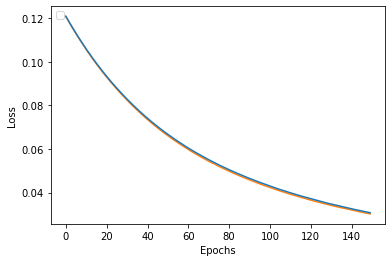

In [57]:
# Plot Loss vs Epochs
plt.legend(loc='upper left')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(range(len(list_train_loss)),list_train_loss,'tab:orange',label='Training Loss')
plt.plot(range(len(list_val_loss)), list_val_loss,'tab:blue',label='Validation Loss')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


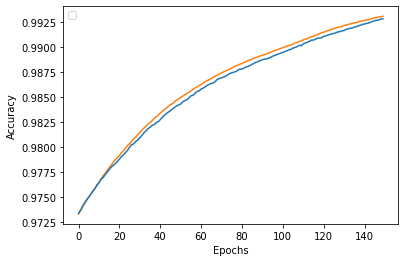

In [58]:
# Plot Accuracy vs Epochs
plt.legend(loc='upper left')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(range(len(list_train_acc)),list_train_acc,'tab:orange',label='Training Accuracy')
plt.plot(range(len(list_val_acc)),list_val_acc,'tab:blue',label='Validation Accuracy')

### Testing

In [22]:
# Get Exclusive test set
final_training_set = set(final_training_list)
all_frames_set = set(all_frames_list)

exclusive_testing_set = all_frames_set - final_training_set

# Sanity check
print(len(all_frames_set), "=", len(exclusive_testing_set), "+", len(final_training_set))

# Randomly shuffle the test list
exclusive_testing_list = list(exclusive_testing_set)
random.seed(42)
random.shuffle(exclusive_testing_list)

8387210 = 7387210 + 1000000


In [23]:
# Create a training list of 1mil files
final_testing_list = []

preexposure_count = 0
postcond_count = 0
postext_count = 0
postret_count = 0

# 1353968 -> Number of frames of postret (smallest class)
for sample in exclusive_testing_list:
    if "preexposure" in sample:
        if preexposure_count < 300000:
            final_testing_list.append(sample)
            preexposure_count += 1
    elif "postcond" in sample:
        if postcond_count < 300000:
            final_testing_list.append(sample)
            postcond_count += 1
    elif "postext" in sample:
        if postext_count < 300000:
            final_testing_list.append(sample)
            postext_count += 1
    elif "postret" in sample:
        if postret_count < 300000:
            final_testing_list.append(sample)
            postret_count += 1
            
print("Length of final_testing_list:", len(final_testing_list), "with", preexposure_count, "Preexposure", postcond_count, "Postcond", postext_count, "Postext", postret_count, "Postret.")

Length of final_testing_list: 1200000 with 300000 Preexposure 300000 Postcond 300000 Postext 300000 Postret.


In [24]:
len(final_testing_list)

1200000

In [25]:
test_latent_array = []
test_label_array = []

In [26]:
len(final_testing_list)

1200000

In [28]:
image_count = 0

for image in final_testing_list[len(test_label_array):]:
    image_count += 1
    if image_count % 10000 == 0:
        print("Processed", image_count, "Images..")
    name = image
    if "preexposure" in name:
        append_name = "/media/data_cifs/anagara8/preexposure_action/"
    elif "postcond" in name:
        append_name = "/media/data_cifs/anagara8/postcond_action/"
    elif "postext" in name:
        append_name = "/media/data_cifs/anagara8/postext_action/"
    elif "postret" in name:
        append_name = "/media/data_cifs/anagara8/postret_action/"
    
    image = cv2.imread(append_name + image)
    image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_AREA)
    tensor_frame = torchvision.transforms.functional.to_tensor(image).unsqueeze(0).cuda()
    with torch.no_grad():
        latent_representation = ae_model_mse.module.encoder(tensor_frame)
    test_latent_array.append(latent_representation.squeeze().cpu().numpy())
    
    # Append One Hot encoded Labels
    if "preexposure" in name:
        test_label_array.append([1.0, 0.0, 0.0, 0.0])
    elif "postcond" in name:
        test_label_array.append([0.0, 1.0, 0.0, 0.0])
    elif "postext" in name:
        test_label_array.append([0.0, 0.0, 1.0, 0.0])
    elif "postret" in name:
        test_label_array.append([0.0, 0.0, 0.0, 1.0])
    else:
        print("ERROR: Incorrect Experiment Phase, no label associated.")
        

Processed 10000 Images..
Processed 20000 Images..
Processed 30000 Images..
Processed 40000 Images..
Processed 50000 Images..
Processed 60000 Images..
Processed 70000 Images..
Processed 80000 Images..
Processed 90000 Images..
Processed 100000 Images..
Processed 110000 Images..
Processed 120000 Images..
Processed 130000 Images..
Processed 140000 Images..


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
# SAVE HERE

In [68]:
len(test_latent_array)

257309

In [69]:
# Testing Dataset
batch_size = 512
# test_data = list(zip(test_latent_array, test_label_array))

# test_data = list(zip(testing_latents, pre_testing_labels))
test_data = list(zip(test_latent_array, test_label_array))
test_dataset = LatentDataset(test_data)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers = 4, shuffle=True)

In [70]:
def test(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    
    predictions = []
    targets = []

    model.eval()
    with torch.no_grad():
        for sample in tqdm(iterator, desc="Validating", leave=False):
            latent, label = sample
        
            latent = latent.to(device)
            label = label.squeeze().to(device)
            
            y_pred = model(latent)

            loss = criterion(y_pred, label)
            acc = calculate_accuracy(y_pred, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            targets.append(label)
            predictions.append(y_pred)

    return epoch_loss / len(iterator), epoch_acc / len(iterator), predictions, targets

In [72]:
# Testing the model
start_time = time.monotonic()
test_loss, test_acc, predictions, targets = test(model, test_loader, criterion, device)

end_time = time.monotonic()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)

# list_test_loss.append(test_loss)
# list_test_acc.append(test_acc)
        
print('Finished Testing in', end_time-start_time, "seconds")

Finished Testing in 33.133653608034365 seconds


In [73]:
print("Test Loss:", test_loss, " Test Acc:", test_acc)

Test Loss: 2.2179864235000157  Test Acc: 0.8553948648881249


[[65118  9806  1933  7083]
 [  926 46091   266  1929]
 [    1  4745 28606  4343]
 [    0  5832   338 80292]]


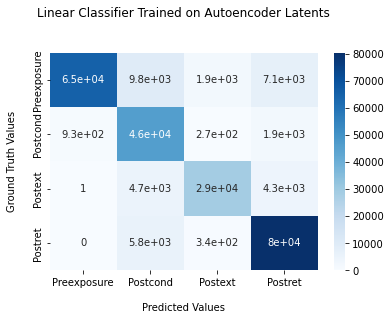

In [74]:
test_predictions = []
test_targets = []

for prediction_batch in predictions:
    for prediction in prediction_batch:
        test_predictions.append(torch.argmax(prediction, dim = 0).cpu().numpy())
        
for target_batch in targets:
    for target in target_batch:
        test_targets.append(torch.argmax(target, dim = 0).cpu().numpy())

from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(test_targets, test_predictions)

print(cf_matrix)

import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Linear Classifier Trained on Autoencoder Latents\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Ground Truth Values\n');

ax.xaxis.set_ticklabels(['Preexposure', 'Postcond', 'Postext', 'Postret'])
ax.yaxis.set_ticklabels(['Preexposure', 'Postcond', 'Postext', 'Postret'])

plt.show()

#### Fused Model

In [78]:
class FusedEncodingModel(nn.Module):
    def __init__(self, autoencoder_model, mlp_model2, autoencoder_model_weights_path, mlp_model_weights_path):
        super().__init__()
        
       
            
        INPUT_DIM = 32
        OUTPUT_DIM = 4

#         mlp_model2 = MLP2(INPUT_DIM, OUTPUT_DIM)

        self.autoencoder_model = autoencoder_model
        self.autoencoder_model.load_state_dict(torch.load(autoencoder_model_weights_path))
        
        self.encoder = self.autoencoder_model.module.encoder
        
        self.mlp_model = mlp_model2
#         self.mlp_model.load_state_dict(torch.load(mlp_model_weights_path))

    def forward(self, x):
        latent_representation = self.encoder(x)
        class_prediction = self.mlp_model(latent_representation)
        
        return class_prediction

In [79]:
fused_model = FusedEncodingModel(ae_model_mse, model, "new_architecture_MSE_e2400.p", "control_animals_expt_mse_e295_v0.9895146048379565.p")
fused_model = fused_model.to(device)
fused_model.eval()

FusedEncodingModel(
  (autoencoder_model): DataParallel(
    (module): newAE(
      (encoder): ResNet18Enc(
        (ResNet18): ResNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): BasicBlock(
              (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (relu): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (1): B

### GradCam

In [80]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layers = [fused_model.encoder.ResNet18.layer3[-1]]
test_image = control_list[1007]
test_image = cv2.imread(test_image)
test_image = cv2.resize(test_image, (224, 224))
plt.figure(figsize=(10,10))
plt.imshow(test_image)
input_tensor = torchvision.transforms.functional.to_tensor(test_image/255.).unsqueeze(0).float()
input_tensor.shape

NameError: name 'control_list' is not defined

In [13]:
import segmentation_models_pytorch as smp
import cv2
import torchvision
import matplotlib.pyplot as plt

In [63]:
model = smp.Unet(
    encoder_name="resnet152",     # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4                 # model output channels (number of classes in your dataset)
)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /home/anagara8/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth
100%|████████████████████████████████████████| 230M/230M [00:05<00:00, 43.2MB/s]


In [64]:
image = cv2.imread("/media/data_cifs/anagara8/postret_action/FC-B_1-6_postretrieval_09-26_09-28video_2018Y_09M_27D_00h_39m_46s_cam_17202346-0000_45652.jpg")
image = torchvision.transforms.functional.to_tensor(image).unsqueeze(0).float()

seg = model(image)

In [65]:
seg = seg.squeeze().detach().cpu().numpy()

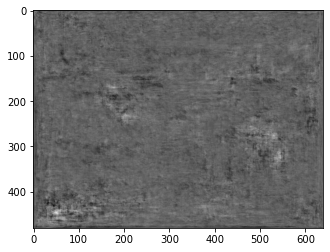

In [68]:
plt.imshow(seg[0], cmap="gray")